# Calculate Arctic Regional atmospheric circulation from CESM2-LE

* **Description**: Reads in and creates regional integrated values from CESM2-LE
* **Input data**: CESM2-LE data, read using intake-esm
* **Output data**: Netcdf with processed ice state for all members
* **Creator**: Alice DuVivier
* **Date**: August 2021

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pop_tools
from datetime import timedelta
import glob
import dask
from matplotlib.gridspec import GridSpec
import pandas as pd

import intake
from distributed import Client
from ncar_jobqueue import NCARCluster


Spin up dask cluster

In [2]:
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
cluster = PBSCluster(
    cores=2, # The number of cores you want
    memory='32 GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    #resource_spec='select=1:ncpus=2:mem=256GB', # Specify resources
    project='P93300665', # Input your project ID here
    walltime='04:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)
# Scale up
cluster.scale(32)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.57:33875,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Read the CESM-LE data 

We will use [`intake-esm`](https://intake-esm.readthedocs.io/en/latest/), which is a data catalog tool.
It enables querying a database for the files we want, then loading those directly as an `xarray.Dataset`.

First step is to set the "collection" for the CESM-LE, which depends on a json file conforming to the [ESM Catalog Specification](https://github.com/NCAR/esm-collection-spec).

In [4]:
# list the variables to load
var_in = 'U10'

# U10, PSL, LHFLX, QFLX, SHFLX

In [5]:
catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'

cat = intake.open_esm_datastore(catalog_file)

/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/intake_esm/core.py:84: DtypeWarning: Columns (5,6,9) have mixed types.Specify dtype option on import or set low_memory=False.
  self._df, self.catalog_file = _fetch_catalog(self.esmcol_data, esmcol_obj, csv_kwargs)


In [6]:
#cat

In [7]:
forcing = 'cmip6'  # do not want smbb data
comp = 'atm'
freq = 'month_1'
exp = 'ssp370'

subset = cat.search(variable=var_in, forcing_variant=forcing, component=comp, frequency=freq, experiment=exp )

In [8]:
subset

,unique
component,1
stream,1
case,50
member_id,50
variable,1
start_time,9
end_time,9
time_range,9
long_name,1
units,1


In [9]:
# check that we only have cmip6, not smbb, data
member_id = list(subset.df.forcing_variant.unique())
print(member_id)

['cmip6']


In [10]:
# check the ensemble member ids
#member_id = list(subset.df.member_id.unique())
#print(member_id)

In [11]:
subset.df.head()

,component,stream,case,member_id,variable,start_time,end_time,time_range,long_name,units,vertical_levels,frequency,path,experiment,forcing_variant,cesm_member_id,control_branch_year,cmip_experiment_id
0,atm,cam.h0,b.e21.BSSP370cmip6.f09_g17.LE2-1001.001,r1i1001p1f1,U10,2015-01,2024-12,201501-202412,10m wind speed,m/s,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1
1,atm,cam.h0,b.e21.BSSP370cmip6.f09_g17.LE2-1001.001,r1i1001p1f1,U10,2025-01,2034-12,202501-203412,10m wind speed,m/s,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1
2,atm,cam.h0,b.e21.BSSP370cmip6.f09_g17.LE2-1001.001,r1i1001p1f1,U10,2035-01,2044-12,203501-204412,10m wind speed,m/s,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1
3,atm,cam.h0,b.e21.BSSP370cmip6.f09_g17.LE2-1001.001,r1i1001p1f1,U10,2045-01,2054-12,204501-205412,10m wind speed,m/s,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1
4,atm,cam.h0,b.e21.BSSP370cmip6.f09_g17.LE2-1001.001,r1i1001p1f1,U10,2055-01,2064-12,205501-206412,10m wind speed,m/s,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1


Now we can use the [`to_dataset_dict`](https://intake-esm.readthedocs.io/en/latest/api.html#intake_esm.core.esm_datastore.to_dataset_dict) method to return a dictionary of `xarray.Dataset`'s. `intake_esm` makes groups of these according to rules in the collection spec file.

We can use the `preprocess` parameter to pass in a function that makes some corrections to the dataset. So first we define a function that does the following:
- fix the time coordinate to be the middle of the interval
- subset to the time-interval 1950-2100

In [12]:
client

<Client: 'tcp://10.12.206.57:33875' processes=32 threads=64, memory=800.00 GiB>

In [13]:
%%time
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    dsets = subset.to_dataset_dict(cdf_kwargs={'chunks': {'time':240}, 'decode_times': True})

#dsets


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 7.18 s, sys: 386 ms, total: 7.57 s
Wall time: 15.7 s


In [14]:
# print names of the dataset keys. 
dsets.keys()

dict_keys(['atm.ssp370.cam.h0.cmip6.U10'])

In [15]:
# Look at just one dataset to see what it looks like. 
# Note that for 1081 there is one member_id, but for 1231 there are 10 member_ids
# these refer to the individual ensemble members!

#dsets['atm.ssp370.cam.h0.cmip6.1101.'+var_in]

In [16]:
# load in the historical and future datasets
futures = []

for key in sorted(dsets.keys()):
    futures.append(dsets[key])
    print(key)

atm.ssp370.cam.h0.cmip6.U10


In [17]:
# Note, this is 14 but several of the ensembles have multiple member_ids because they are the micro
len(futures)

1

In [18]:
# Now put these into an array
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    future_ds = xr.concat(futures, dim='member_id', data_vars="minimal", coords="minimal", compat="override")


In [19]:
# note that the historical and future xarray datasets have the same coordinates and dimensions *except* time, 
# so we need to concatenate over time
ds_all = future_ds

In [20]:
ds_all[var_in]

,Array,Chunk
Bytes,10.63 GiB,25.31 MiB
Shape,"(50, 1032, 192, 288)","(1, 120, 192, 288)"
Count,2250 Tasks,450 Chunks
Type,float32,numpy.ndarray


In [21]:
ds_all.time

<xarray.DataArray 'time' (time: 1032)>
array([cftime.DatetimeNoLeap(2015, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 4, 1, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2100, 11, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2101, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    long_name:  time
    bounds:     time_bnds

In [22]:
ds_all

<xarray.Dataset>
Dimensions:       (lat: 192, zlon: 1, nbnd: 2, lon: 288, lev: 32, ilev: 33, time: 1032, member_id: 50)
Coordinates:
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * zlon          (zlon) float64 0.0
  * lon           (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time          (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
  * member_id     (member_id) <U12 'r10i1181p1f1' ... 'r9i1301p1f1'
Dimensions without coordinates: nbnd
Data variables: (12/27)
    zlon_bnds     (zlon, nbnd) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    gw            (lat) float64 dask.array<chunksize=(192,), meta=np.ndarray>
    hyam          (lev) float64 dask.array<chunksize=(32,), meta=np.ndarray>
    hybm          (lev) float64 dask.array<chunksize=(32,), meta=np.ndarray>
    P0            float64 ...
    hyai          (ilev) float64 dask.array<chunksize=(33,), meta=np.ndarray>
    ...            ...
    n2ovmr        (time) float64 dask.array<chunksize=(120,), meta=np.ndarray>
    f11vmr        (time) float64 dask.array<chunksize=(120,), meta=np.ndarray>
    f12vmr        (time) float64 dask.array<chunksize=(120,), meta=np.ndarray>
    sol_tsi       (time) float64 dask.array<chunksize=(120,), meta=np.ndarray>
    nsteph        (time) float64 dask.array<chunksize=(120,), meta=np.ndarray>
    U10           (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 120, 192, 288), meta=np.ndarray>
Attributes:
    topography_file:         /mnt/lustre/share/CESM/cesm_input/atm/cam/topo/f...
    time_period_freq:        month_1
    logname:                 sunseon
    source:                  CAM
    intake_esm_varname:      ['U10']
    Conventions:             CF-1.0
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    host:                    mom1
    intake_esm_dataset_key:  atm.ssp370.cam.h0.cmip6.U10

In [23]:
# Shift months by one to be center of time period.
# Take average of the time bounds to get middle of month
# will lose some attributes with time, so may need to put this back in later...
ds_all.time_bnds.load().mean(dim='nbnd')

<xarray.DataArray 'time_bnds' (time: 1032)>
array([cftime.DatetimeNoLeap(2015, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2100, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00

In [24]:
ds_all['time'] = ds_all.time_bnds.load().mean(dim='nbnd')

In [25]:
ds_all.time

<xarray.DataArray 'time' (time: 1032)>
array([cftime.DatetimeNoLeap(2015, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2100, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00

In [26]:
ds_all

<xarray.Dataset>
Dimensions:       (lat: 192, zlon: 1, nbnd: 2, lon: 288, lev: 32, ilev: 33, time: 1032, member_id: 50)
Coordinates:
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * zlon          (zlon) float64 0.0
  * lon           (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time          (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id     (member_id) <U12 'r10i1181p1f1' ... 'r9i1301p1f1'
Dimensions without coordinates: nbnd
Data variables: (12/27)
    zlon_bnds     (zlon, nbnd) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    gw            (lat) float64 dask.array<chunksize=(192,), meta=np.ndarray>
    hyam          (lev) float64 dask.array<chunksize=(32,), meta=np.ndarray>
    hybm          (lev) float64 dask.array<chunksize=(32,), meta=np.ndarray>
    P0            float64 ...
    hyai          (ilev) float64 dask.array<chunksize=(33,), meta=np.ndarray>
    ...            ...
    n2ovmr        (time) float64 dask.array<chunksize=(120,), meta=np.ndarray>
    f11vmr        (time) float64 dask.array<chunksize=(120,), meta=np.ndarray>
    f12vmr        (time) float64 dask.array<chunksize=(120,), meta=np.ndarray>
    sol_tsi       (time) float64 dask.array<chunksize=(120,), meta=np.ndarray>
    nsteph        (time) float64 dask.array<chunksize=(120,), meta=np.ndarray>
    U10           (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 120, 192, 288), meta=np.ndarray>
Attributes:
    topography_file:         /mnt/lustre/share/CESM/cesm_input/atm/cam/topo/f...
    time_period_freq:        month_1
    logname:                 sunseon
    source:                  CAM
    intake_esm_varname:      ['U10']
    Conventions:             CF-1.0
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    host:                    mom1
    intake_esm_dataset_key:  atm.ssp370.cam.h0.cmip6.U10

## Mask Arctic Ocean only

In [29]:
ds_masks = xr.open_mfdataset('/glade/p/cgd/ppc/duvivier/cesm2_arctic_cyclones/rufmod_analysis/version_5/mask_plots/ATM_MASK_ArcOc.nc')


In [30]:
my_mask = ds_masks['atm_ArcOc_mask']

In [31]:
my_mask

<xarray.DataArray 'atm_ArcOc_mask' (lat: 192, lon: 288)>
dask.array<open_dataset-da90c46d10fd21b010e08c82e53c0a7aatm_ArcOc_mask, shape=(192, 288), dtype=float32, chunksize=(192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

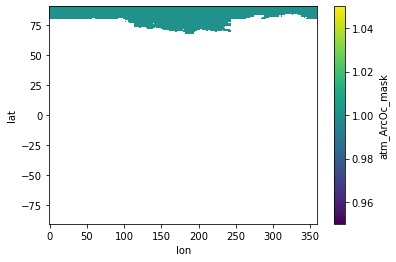

In [32]:
my_mask.plot()

In [36]:
ds_all[var_in].member_id

<xarray.DataArray 'member_id' (member_id: 50)>
array(['r10i1181p1f1', 'r10i1231p1f1', 'r10i1251p1f1', 'r10i1281p1f1',
       'r10i1301p1f1', 'r1i1001p1f1', 'r1i1231p1f1', 'r1i1251p1f1',
       'r1i1281p1f1', 'r1i1301p1f1', 'r2i1021p1f1', 'r2i1231p1f1',
       'r2i1251p1f1', 'r2i1281p1f1', 'r2i1301p1f1', 'r3i1041p1f1',
       'r3i1231p1f1', 'r3i1251p1f1', 'r3i1281p1f1', 'r3i1301p1f1',
       'r4i1061p1f1', 'r4i1231p1f1', 'r4i1251p1f1', 'r4i1281p1f1',
       'r4i1301p1f1', 'r5i1081p1f1', 'r5i1231p1f1', 'r5i1251p1f1',
       'r5i1281p1f1', 'r5i1301p1f1', 'r6i1101p1f1', 'r6i1231p1f1',
       'r6i1251p1f1', 'r6i1281p1f1', 'r6i1301p1f1', 'r7i1121p1f1',
       'r7i1231p1f1', 'r7i1251p1f1', 'r7i1281p1f1', 'r7i1301p1f1',
       'r8i1141p1f1', 'r8i1231p1f1', 'r8i1251p1f1', 'r8i1281p1f1',
       'r8i1301p1f1', 'r9i1161p1f1', 'r9i1231p1f1', 'r9i1251p1f1',
       'r9i1281p1f1', 'r9i1301p1f1'], dtype='<U12')
Coordinates:
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'

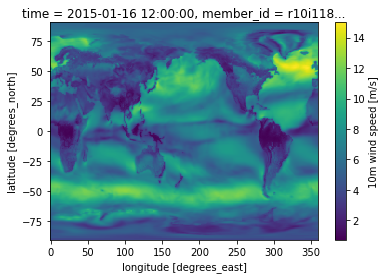

In [38]:
# check data
ds_all[var_in].sel(member_id='r10i1181p1f1').isel(time=0).plot()

In [39]:
#mask just NH cap
ds_all_masked = ds_all.where(my_mask==1)

/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


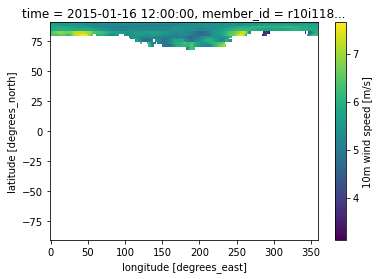

In [40]:
#just test that it worked properly
ds_all_masked[var_in].sel(member_id='r10i1181p1f1').isel(time=0).plot()

## Calculate regional averages

Just average over everything we have not masked out

In [41]:
total = ds_all_masked[var_in].mean(dim='lat').mean(dim='lon')

In [42]:
ds_all_masked[var_in]

,Array,Chunk
Bytes,5.26 GiB,12.52 MiB
Shape,"(50, 1032, 95, 288)","(1, 120, 95, 288)"
Count,3154 Tasks,450 Chunks
Type,float32,numpy.ndarray


In [43]:
# set some values for the data
longname = ds_all_masked[var_in].long_name+' 70-90N'
units = ds_all_masked[var_in].units

### Actually load the data now

Before, all the calculations were "lazy" version

In [44]:
%%time
## slow step
total.load()

CPU times: user 1.72 s, sys: 82.8 ms, total: 1.8 s
Wall time: 4.15 s


<xarray.DataArray 'U10' (member_id: 50, time: 1032)>
array([[5.634721 , 5.2328434, 6.475678 , ..., 6.898589 , 7.1878376,
        7.661621 ],
       [6.18573  , 7.45481  , 5.5893197, ..., 8.071215 , 7.9096527,
        6.6504607],
       [5.736451 , 5.189871 , 5.9758244, ..., 6.928364 , 7.002052 ,
        7.8430853],
       ...,
       [4.825147 , 4.9817758, 5.721743 , ..., 6.372099 , 6.4021077,
        6.954005 ],
       [5.443968 , 7.012642 , 6.0131917, ..., 6.8830533, 6.2652917,
        6.101111 ],
       [6.440661 , 7.1379385, 6.479447 , ..., 7.3694425, 7.4214478,
        5.8430104]], dtype=float32)
Coordinates:
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'

In [45]:
# check times in the array
#total.time[0]
#yyyy = total.coords['time.year']
#mm = total.coords['time.month']

In [46]:
total.coords

Coordinates:
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'

In [47]:
total

<xarray.DataArray 'U10' (member_id: 50, time: 1032)>
array([[5.634721 , 5.2328434, 6.475678 , ..., 6.898589 , 7.1878376,
        7.661621 ],
       [6.18573  , 7.45481  , 5.5893197, ..., 8.071215 , 7.9096527,
        6.6504607],
       [5.736451 , 5.189871 , 5.9758244, ..., 6.928364 , 7.002052 ,
        7.8430853],
       ...,
       [4.825147 , 4.9817758, 5.721743 , ..., 6.372099 , 6.4021077,
        6.954005 ],
       [5.443968 , 7.012642 , 6.0131917, ..., 6.8830533, 6.2652917,
        6.101111 ],
       [6.440661 , 7.1379385, 6.479447 , ..., 7.3694425, 7.4214478,
        5.8430104]], dtype=float32)
Coordinates:
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'

### Plot just to check

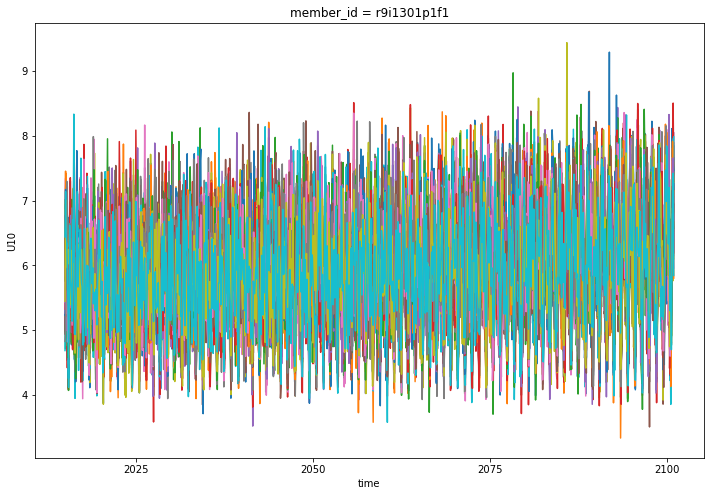

In [48]:
import nc_time_axis
# Setup the figure
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)

# Loop through and plot each member_id all months in 251 years
for member_id in total.member_id.values:
    total.sel(member_id=member_id).plot(ax=ax, label=member_id)

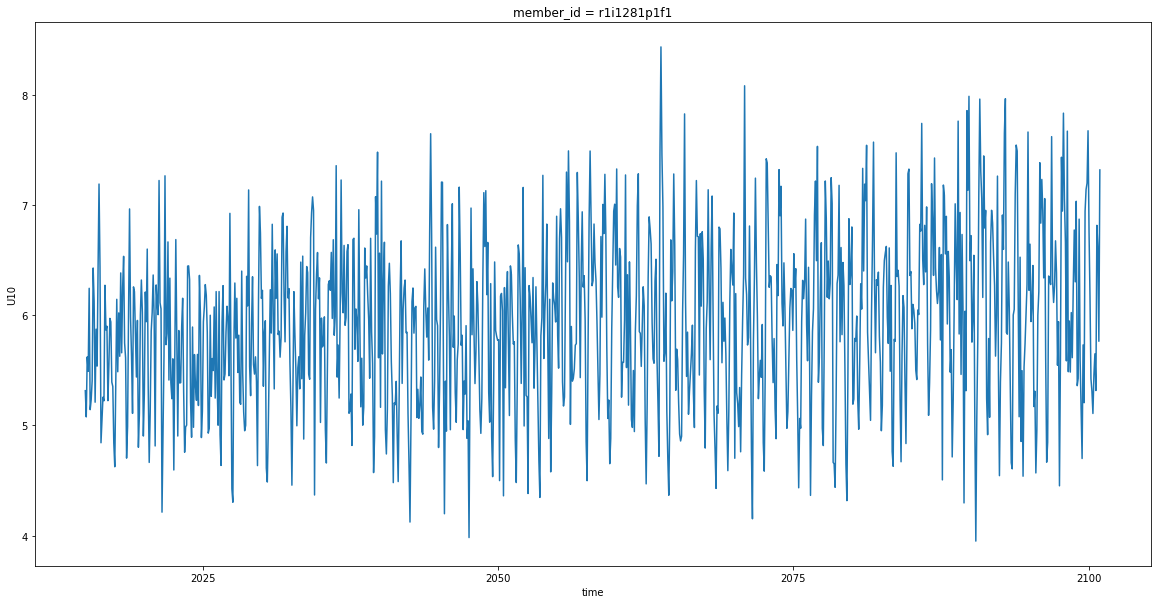

In [49]:
# Setup the figure
fig = plt.figure(figsize=(20, 10))
ax = plt.subplot(111)

# Plot just one to check
total.sel(member_id='r1i1281p1f1').plot(ax=ax, label='r1i1281p1f1')

### Save the timeseries

In [50]:
fout = 'CESM2-LE_all_transient_regional_avg_'+var_in

In [51]:
ds_to_save = xr.Dataset({'regional_totals': (['member_id','time'], total.data)},
                        coords={'time':(['time'],total.time.values),
                                'member_id':(['member_id'],total.member_id.values)},
                        attrs={'Author': 'Alice DuVivier', 'units':units, 'longname':longname})

In [52]:
# double check dataset we plan to save
ds_to_save

<xarray.Dataset>
Dimensions:          (member_id: 50, time: 1032)
Coordinates:
  * time             (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id        (member_id) <U12 'r10i1181p1f1' ... 'r9i1301p1f1'
Data variables:
    regional_totals  (member_id, time) float32 5.635 5.233 6.476 ... 7.421 5.843
Attributes:
    Author:    Alice DuVivier
    units:     m/s
    longname:  10m wind speed 70-90N

In [53]:
ds_to_save.to_netcdf(fout+'.nc')  # how to save file